Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License. 

# 3D Segmentation with UNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/unet_segmentation_3d_ignite.ipynb)

## Setup environment

In [1]:
import sys
print(sys.executable)

/vol/bitbucket/jkl223/cv_venv/bin/python


In [4]:
!python -c "import monai" || pip install -q "monai-weekly[ignite, nibabel, tensorboard, mlflow]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
^C
ERROR: Operation cancelled by user


## Setup imports

In [1]:
import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile

import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch, DataLoader
from monai.handlers import (
    MeanDice,
    MLFlowHandler,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandSpatialCrop,
    ResizeWithPadOrCrop,
    Resize,
    ScaleIntensity,
)
from monai.utils import first

import ignite
import torch

print_config()

MONAI version: 1.4.dev2428
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d242d8f1b2876133bcafbe7fa5d967728a74998
MONAI __file__: /vol/bitbucket/<username>/cv_venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.17.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.3
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about ins

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

Device: cuda


In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp42b9hntl


## Setup logging

In [4]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Setup demo data

In [4]:
for i in range(40):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes=1)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"im{i}.nii.gz"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i}.nii.gz"))

images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
segs = sorted(glob.glob(os.path.join(root_dir, "seg*.nii.gz")))

In [5]:
import os
sys.path.append(os.path.abspath(".."))

from ACDCDataset import ACDCDataset

dataset_path = '/vol/bitbucket/jkl223/ACDC'
dataset = ACDCDataset(dataset_path, model_type='3D')#, training=False)
images, segs = dataset.image_train_paths, dataset.label_train_paths

INFO:ACDCDataset:Loaded dataset for 3D training


## Setup transforms, dataset

In [6]:
output_size = (192, 192, 16)

# Define transforms for image and segmentation
imtrans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        EnsureChannelFirst(),
        ResizeWithPadOrCrop(output_size),
        # RandSpatialCrop((96, 96, 96), random_size=False),
    ]
)
segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ResizeWithPadOrCrop(output_size),
        # RandSpatialCrop((96, 96, 96), random_size=False),
    ]
)

# Define nifti dataset, dataloader
ds = ArrayDataset(images, imtrans, segs, segtrans)
loader = DataLoader(ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = first(loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 192, 192, 16]) torch.Size([10, 1, 192, 192, 16])


## Create Model, Loss, Optimizer

In [7]:
# Create UNet, DiceLoss and Adam optimizer
# device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,#4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)

## Create supervised_trainer using ignite

In [8]:
# Create trainer
trainer = ignite.engine.create_supervised_trainer(net, opt, loss, device, False)

## Setup event handlers for checkpointing and logging

In [12]:
# optional section for checkpoint and tensorboard logging
# adding checkpoint handler to save models (network
# params and optimizer stats) during training
log_dir = os.path.join(root_dir, "logs")
checkpoint_handler = ignite.handlers.ModelCheckpoint(log_dir, "net", n_saved=10, require_empty=False)
trainer.add_event_handler(
    event_name=ignite.engine.Events.EPOCH_COMPLETED,
    handler=checkpoint_handler,
    to_save={"net": net, "opt": opt},
)

# StatsHandler prints loss at every iteration
# user can also customize print functions and can use output_transform to convert
# engine.state.output if it's not a loss value
train_stats_handler = StatsHandler(name="trainer", output_transform=lambda x: x)
train_stats_handler.attach(trainer)

# TensorBoardStatsHandler plots loss at every iteration
train_tensorboard_stats_handler = TensorBoardStatsHandler(log_dir=log_dir, output_transform=lambda x: x)
train_tensorboard_stats_handler.attach(trainer)

# MLFlowHandler plots loss at every iteration on MLFlow web UI
mlflow_dir = os.path.join(log_dir, "mlruns")
train_mlflow_handler = MLFlowHandler(tracking_uri=Path(mlflow_dir).as_uri(), output_transform=lambda x: x)
train_mlflow_handler.attach(trainer)

## Add Validation every N epochs

In [13]:
# optional section for model validation during training
validation_every_n_epochs = 1
# Set parameters for validation
metric_name = "Mean_Dice"
# add evaluation metric to the evaluator engine
val_metrics = {metric_name: MeanDice()}
post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_label = Compose([AsDiscrete(threshold=0.5)])
# Ignite evaluator expects batch=(img, seg) and
# returns output=(y_pred, y) at every iteration,
# user can add output_transform to return other values
evaluator = ignite.engine.create_supervised_evaluator(
    net,
    val_metrics,
    device,
    True,
    output_transform=lambda x, y, y_pred: (
        [post_pred(i) for i in decollate_batch(y_pred)],
        [post_label(i) for i in decollate_batch(y)],
    ),
)

# create a validation data loader
val_imtrans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        EnsureChannelFirst(),
        ResizeWithPadOrCrop(output_size),
        # Resize((96, 96, 96)),
    ]
)
val_segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ResizeWithPadOrCrop(output_size),
        # Resize((96, 96, 96)),
    ]
)
val_ds = ArrayDataset(images[90:], val_imtrans, segs[90:], val_segtrans)
val_loader = DataLoader(val_ds, batch_size=5, shuffle=True, num_workers=6, pin_memory=torch.cuda.is_available())


@trainer.on(ignite.engine.Events.EPOCH_COMPLETED(every=validation_every_n_epochs))
def run_validation(engine):
    evaluator.run(val_loader)


# Add stats event handler to print validation stats via evaluator
val_stats_handler = StatsHandler(
    name="evaluator",
    # no need to print loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_stats_handler.attach(evaluator)

# add handler to record metrics to TensorBoard at every validation epoch
val_tensorboard_stats_handler = TensorBoardStatsHandler(
    log_dir=log_dir,
    # no need to plot loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_tensorboard_stats_handler.attach(evaluator)

# add handler to record metrics to MLFlow at every validation epoch
val_mlflow_handler = MLFlowHandler(
    tracking_uri=Path(mlflow_dir).as_uri(),
    # no need to plot loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_mlflow_handler.attach(evaluator)

# add handler to draw the first image and the corresponding
# label and model output in the last batch
# here we draw the 3D output as GIF format along Depth
# axis, at every validation epoch
val_tensorboard_image_handler = TensorBoardImageHandler(
    log_dir=log_dir,
    batch_transform=lambda batch: (batch[0], batch[1]),
    output_transform=lambda output: output[0],
    global_iter_transform=lambda x: trainer.state.epoch,
)
evaluator.add_event_handler(
    event_name=ignite.engine.Events.EPOCH_COMPLETED,
    handler=val_tensorboard_image_handler,
)

## Run training loop

In [ ]:
train_ds = ArrayDataset(images[:90], imtrans, segs[:90], segtrans)
train_loader = DataLoader(
    train_ds,
    batch_size=10,
    shuffle=True,
    num_workers=6,
    pin_memory=torch.cuda.is_available(),
)

for images, labels in train_loader:
    labels = labels.expand(-1, 4, -1, -1, -1)
    label = labels[0]
    print(np.unique(label[0]))
    print(np.unique(label[1]))
    print(np.unique(label[2]))
    print(np.unique(label[3]))
    break

In [21]:
# create a training data loader
train_ds = ArrayDataset(images[:90], imtrans, segs[:90], segtrans)

train_loader = DataLoader(
    train_ds,
    batch_size=10,
    shuffle=True,
    num_workers=6,
    pin_memory=torch.cuda.is_available(),
)

import torch
import torch.nn as nn

def debug_trainer(engine, batch):
    net.train()
    opt.zero_grad()
    inputs, labels = batch
    
    # labels = labels.expand(-1, 4, -1, -1, -1)
    # print(labels[0])
    
    inputs = inputs.to(device)
    # labels = labels_one_hot.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = net(inputs)
    print(f'Forward pass - Outputs shape: {outputs.shape}, Labels shape: {labels.shape}')
    
    # Compute loss
    loss_ = loss(outputs, labels)
    print(f'Loss computed - Loss value: {loss_.item()}')
    
    # Backward pass
    loss_.backward()
    opt.step()
    
    return loss_.item()

trainer = ignite.engine.Engine(debug_trainer)

@trainer.on(ignite.engine.Events.ITERATION_STARTED)
def check_shapes(engine):
    batch = engine.state.batch
    inputs, labels = batch
    print(f'Batch {engine.state.iteration} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}')

max_epochs = 100
state = trainer.run(train_loader, max_epochs)

INFO:ignite.engine.engine.Engine:Engine run starting with max_epochs=100.
Batch 1 - Inputs shape: torch.Size([10, 1, 192, 192, 16]), Labels shape: torch.Size([10, 1, 192, 192, 16])
Forward pass - Outputs shape: torch.Size([10, 1, 192, 192, 16]), Labels shape: torch.Size([10, 1, 192, 192, 16])
Loss computed - Loss value: 0.8943635821342468
Batch 2 - Inputs shape: torch.Size([10, 1, 192, 192, 16]), Labels shape: torch.Size([10, 1, 192, 192, 16])
Forward pass - Outputs shape: torch.Size([10, 1, 192, 192, 16]), Labels shape: torch.Size([10, 1, 192, 192, 16])
Loss computed - Loss value: 0.8167340159416199
Batch 3 - Inputs shape: torch.Size([10, 1, 192, 192, 16]), Labels shape: torch.Size([10, 1, 192, 192, 16])
Forward pass - Outputs shape: torch.Size([10, 1, 192, 192, 16]), Labels shape: torch.Size([10, 1, 192, 192, 16])
Loss computed - Loss value: 0.8005781173706055
Batch 4 - Inputs shape: torch.Size([10, 1, 192, 192, 16]), Labels shape: torch.Size([10, 1, 192, 192, 16])
Forward pass - Out

In [22]:
torch.save(net.state_dict(), 'unet3D.pth')

In [9]:
# Create a new instance of the model (same architecture)
new_net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,#4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)
new_net.load_state_dict(torch.load('unet3D.pth'))
new_net.to(device)  # Move the model to the appropriate device if necessary
new_net.eval()  # Set the model to evaluation mode

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se

In [15]:
test_images, test_segs = dataset.image_test_paths, dataset.label_test_paths

# create a test data loader
test_imtrans = Compose(
    [
        LoadImage(image_only=True),
        # ScaleIntensity(),
        EnsureChannelFirst(),
        ResizeWithPadOrCrop(output_size),
        # Resize((96, 96, 96)),
    ]
)
test_segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ResizeWithPadOrCrop(output_size),
        # Resize((96, 96, 96)),
    ]
)

test_ds = ArrayDataset(test_images, test_imtrans, test_segs, test_segtrans)
test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)

# Switch the model to evaluation mode
net.eval()

# Assuming test_loader is a DataLoader for the test data
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch  # Assuming the DataLoader provides inputs and labels
        inputs = inputs.to(device)
        outputs = net(inputs)
        
        # Process outputs (e.g., apply softmax if needed, get predictions)
        predictions = torch.softmax(outputs, dim=1)
        
        # Do something with the predictions
        # print(predictions)


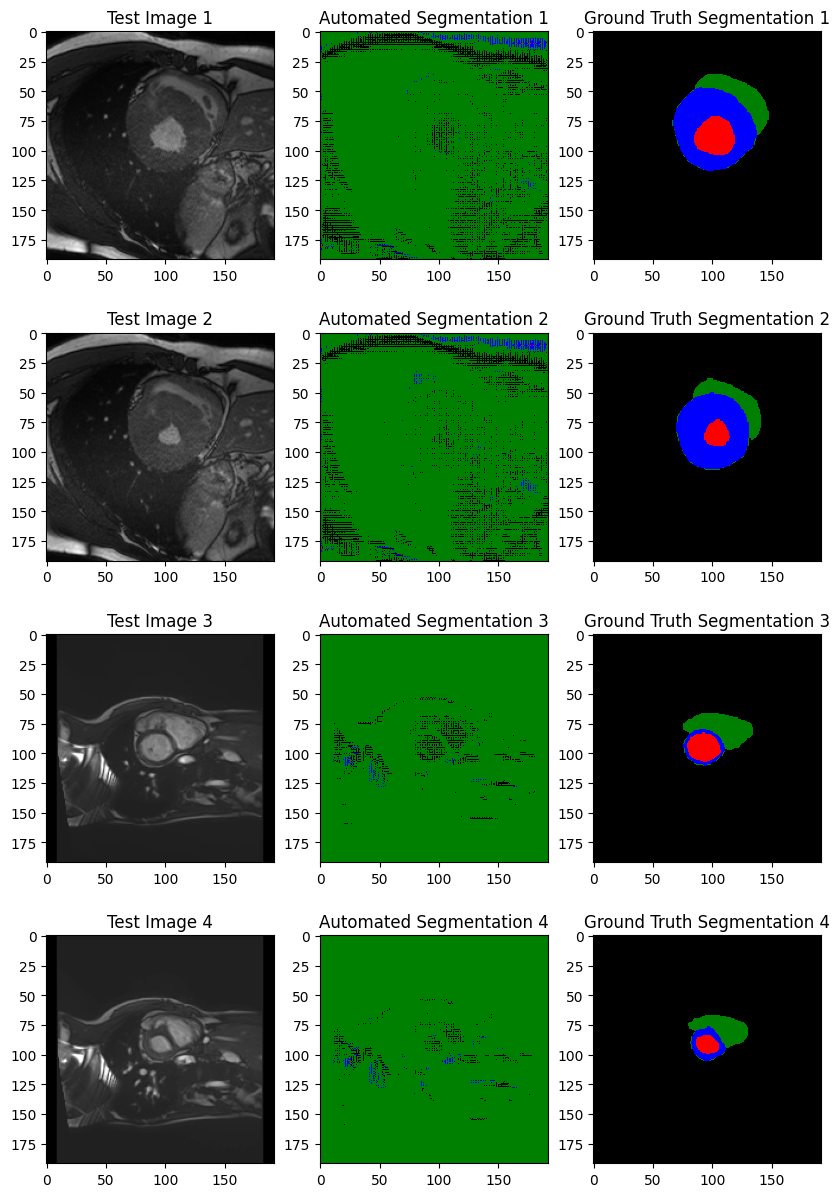

In [16]:
images_np = inputs.cpu().numpy()
masks_np = outputs.cpu().numpy()

slice_idx = 5

import matplotlib.pyplot as plt
from matplotlib import colors

# create plot
plt.figure(figsize=(10, 15))
for i in range(4):
    # plot input image
    image = images_np[i].squeeze()
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(image[:, :, slice_idx], cmap='gray')
    plt.title(f'Test Image {i + 1}')

    # plot automated segmentation
    mask = masks_np[i].squeeze()
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(mask[:, :, slice_idx], cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    plt.title(f'Automated Segmentation {i + 1}')

    # plot ground truth
    label = labels[i].squeeze()
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(label[:, :, slice_idx], cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    plt.title(f'Ground Truth Segmentation {i + 1}')

## Visualizing Tensorboard logs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=$log_dir

Expected training curve on TensorBoard:
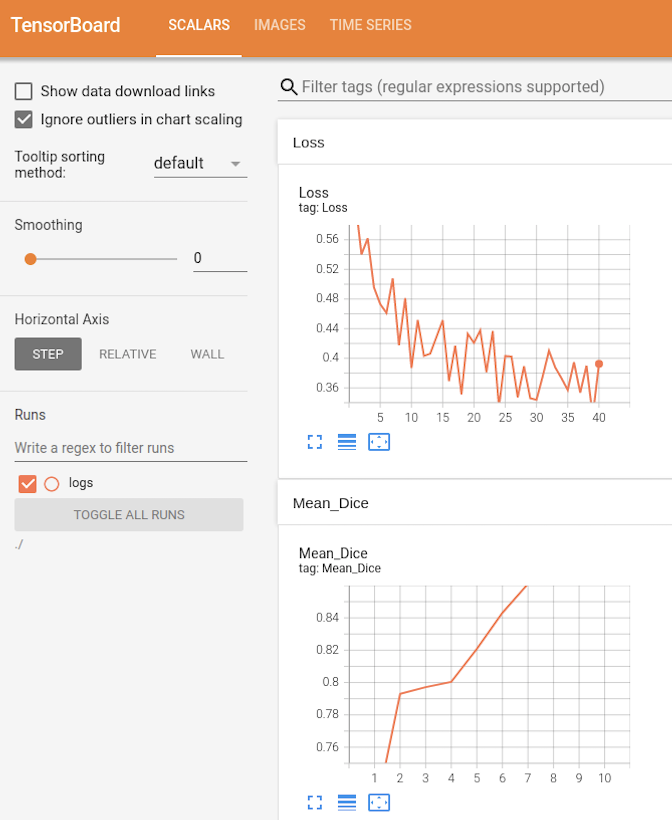 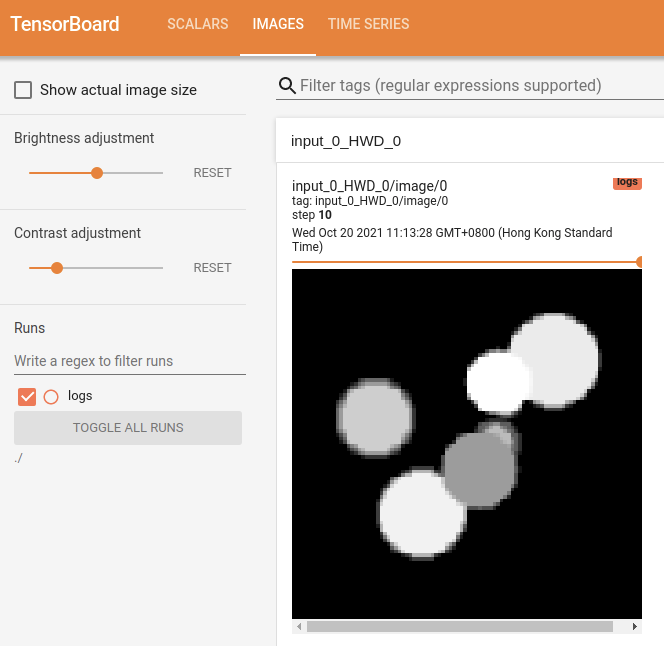

## Visualizing training status in MLFlow

As `mlflow` is not IPython component, please switch to the `log_dir` and execute command `mlflow ui` to launch MLFlow UI.

Expected training curve on MLFlow UI:

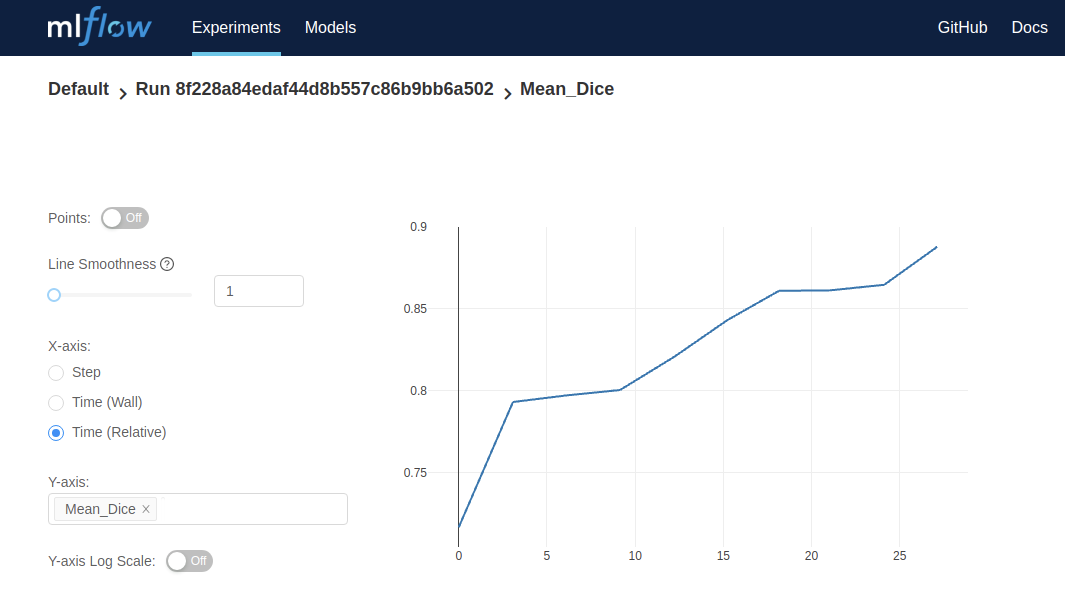

## Cleanup data directory

Remove directory if a temporary was used.

In [4]:
if directory is None:
    shutil.rmtree(root_dir)

In [3]:
shutil.rmtree("/tmp/tmp42b9hntl")